## Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do you best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard) (but don't start learning about it now, it takes a while to get it up and running).



--------
## My implementation

----------
### Libraries & functions

In [89]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib

from astroML.classification import GMMBayes

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA


plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15

In [2]:
'''
function that assigns label 0 to the true positives (recognized quasars),
1 to the true negatives (recognized galaxies), 
2 to the false negatives (quazars not recognized)
& 3 to the false positives (galaxies identified as quasars)
'''

def results(y_true, y_predicted):
    
    tn = np.logical_and(y_predicted == y_true, y_true == 0)
    fn = np.logical_and(y_predicted != y_true, y_true == 1)
    fp = np.logical_and(y_predicted != y_true, y_true == 0)
    
    label = np.zeros(len(y_true))  
    label[tn] = 1                     
    label[fn] = 2
    label[fp] = 3
    
    return label


'''
assigns to data labelled 'QS0' the label 1, 0 to data labelled 'GALAXY' 
'''
def numlabels(y):
    newy = np.zeros(len(y))
    for i in range(len(y)):
        if y[i] =='QSO':
            newy[i] = 1
    return newy


''' 
Scales data around zero mean and with unit variance
'''
def cleandata(data):
    return (data-data.mean())/data.std()

--------

### Data

In [3]:
# Read data
path = '/Users/giuliamariaborro/box/reps/astrostatistics_bicocca_2022/solutions/'
data=np.genfromtxt(path+'galaxyquasar.csv', delimiter=',',names=True,usecols=(0,1,2,3,4,6),dtype=float,comments='#')
names = data.dtype.names
data=np.genfromtxt(path+'galaxyquasar.csv', delimiter=',',skip_header=1,usecols=(0,1,2,3,4,6),dtype=float)
d = dict(zip(names, data.T))
lab=np.genfromtxt(path+'galaxyquasar.csv', delimiter=',',skip_header=1,usecols=5,dtype=str)

# Create arrays for the (u−g), (g−r), (r−i), and (i−z) colors
for diff in ['ug', 'gr', 'ri', 'iz']:
    d[diff]=d[diff[0]]-d[diff[1]] 
d['lab']=lab

Store color data and labels in X,y

In [4]:
# Prepare data (zero mean, unit variance)
X = np.array([d['ug'], d['gr'],d['ri'],
              d['iz']]).T

Xnn = np.array([cleandata(d['ug']), cleandata(d['gr']), cleandata(d['ri']),
              cleandata(d['iz'])]).T
y = numlabels(d['lab'])
print(X.shape)

(50000, 4)


In [5]:
# test train split
Xnn_train, Xnn_test, y_train, y_test = train_test_split(
     Xnn, y, test_size=0.3, random_state=8)

-------
### Neural network with MLPClassifier

In [6]:
# model
clf1 = MLPClassifier(hidden_layer_sizes=5, activation='relu', solver='adam', 
                    learning_rate_init=0.001, random_state=8)

# fit & predict
clf1.fit(Xnn_train, y_train)
y1_pred = clf1.predict(Xnn_test)

##### Optimize model with RandomizedSearchCV

Do a 5-fold cross validation to get the best hidden layers size and learning rate initialization

In [7]:
clf = MLPClassifier(activation='relu', solver='adam', max_iter=1000, random_state=6)

# hidden layers from 1 to 3 all with the same number of neaurons, that goes from 1 to 11
HL = np.array([[b, np.full((2), b), np.full((3), b)] for b in range(1,11)])
print(HL)
HL = HL.flatten()

par={'hidden_layer_sizes': HL, 
    'learning_rate_init': np.linspace(0.001,0.01,10)}


search = RandomizedSearchCV(clf, param_distributions=par, cv=5, n_jobs=-1) 
search.fit(Xnn_train, y_train)

# results
best_lr = search.best_params_['learning_rate_init']
best_hls = search.best_params_['hidden_layer_sizes']




#----------------- Grid Search -------------------------
'''
it takes a lot. results are rewritten in the next cell
'''
#grid = GridSearchCV(clf, param_grid=par, cv=5, n_jobs=-1) 
#grid.fit(X_train, y_train)

# results
#best_lr = grid.best_params_['learning_rate_init']
#best_hls = grid.best_params_['hidden_layer_sizes'] 
print('best learning rate:', best_lr, 
      '\n best hidden layers size:',best_hls)

[[1 array([1, 1]) array([1, 1, 1])]
 [2 array([2, 2]) array([2, 2, 2])]
 [3 array([3, 3]) array([3, 3, 3])]
 [4 array([4, 4]) array([4, 4, 4])]
 [5 array([5, 5]) array([5, 5, 5])]
 [6 array([6, 6]) array([6, 6, 6])]
 [7 array([7, 7]) array([7, 7, 7])]
 [8 array([8, 8]) array([8, 8, 8])]
 [9 array([9, 9]) array([9, 9, 9])]
 [10 array([10, 10]) array([10, 10, 10])]]


/var/folders/l6/xx2lbds11l37fqdhf3bcglx80000gn/T/ipykernel_15898/1589088066.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  HL = np.array([[b, np.full((2), b), np.full((3), b)] for b in range(1,11)])


best learning rate: 0.006 
 best hidden layers size: [6 6]


In [8]:
# results from GridSearchCV:
#best_lr = 0.007
#best_hls = [9, 9, 9]

In [10]:
# best model
clf2 = MLPClassifier(activation='relu', hidden_layer_sizes=best_hls, 
                    learning_rate_init=best_lr, solver='adam', random_state=8)

# fit & predict
clf2.fit(Xnn_train, y_train)
y2_pred = clf2.predict(Xnn_test)

##### Compare models

Compare the models made with the neural network and the classifications made with GMMB and KNN (using all colors this time!)

Get the false positive rate, true positive rate for the two models

In [85]:
# old models:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)


gmmb = GMMBayes(13, random_state=8)
gmmb.fit(X_train, y_train)
y_pred_gmmb = gmmb.predict(X_test)

knn = KNeighborsClassifier(11)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)



Confusion matrix:

In [86]:
print('\n accuracy for GMMB:', accuracy_score(y_test, y_pred_gmmb),
     '\n accuracy for KNN:', accuracy_score(y_test, y_pred_knn),
      '\n accuracy for first NN:', accuracy_score(y_test, y1_pred),
     '\n accuracy for optimized NN:', accuracy_score(y_test, y2_pred))


print('\n GMMB: \n', confusion_matrix(y_test, y_pred_gmmb))
print('\n KNNC: \n', confusion_matrix(y_test, y_pred_knn))
print('\n NN first model: \n', confusion_matrix(y_test, y1_pred))
print('\n NN optimized model: \n', confusion_matrix(y_test, y2_pred))


 accuracy for GMMB: 0.9848 
 accuracy for KNN: 0.986 
 accuracy for first NN: 0.9844 
 accuracy for optimized NN: 0.9858666666666667

 GMMB: 
 [[12745   100]
 [  128  2027]]

 KNNC: 
 [[12769    76]
 [  134  2021]]

 NN first model: 
 [[12771    74]
 [  160  1995]]

 NN optimized model: 
 [[12775    70]
 [  142  2013]]


See the results in u-g g-r colorplot:

Label = 0: quasars correctly identified. 
Label = 1: galaxies correctly identified. 
Label = 2: quasars exchanged for galaxies. 
Label = 3: galaxies exchanged for quasars.


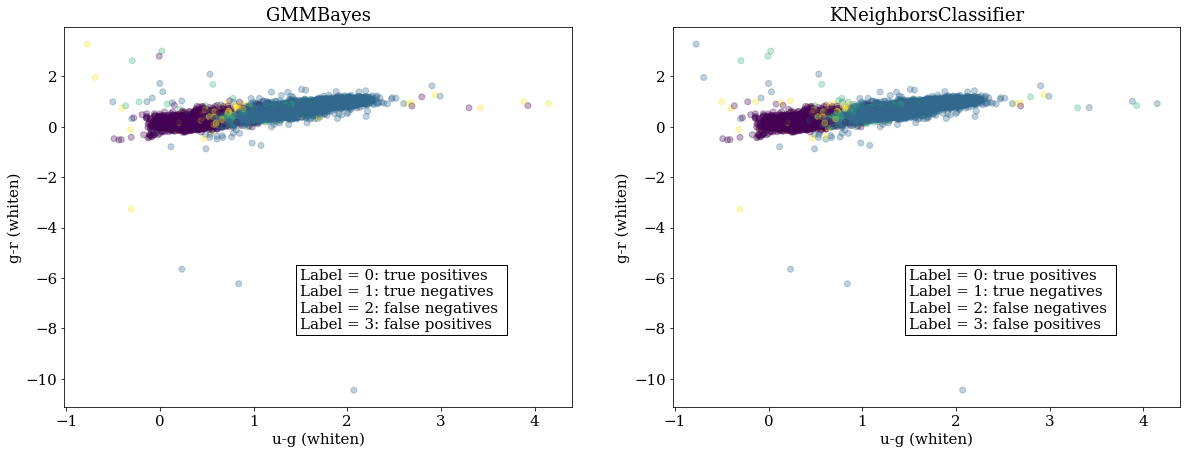

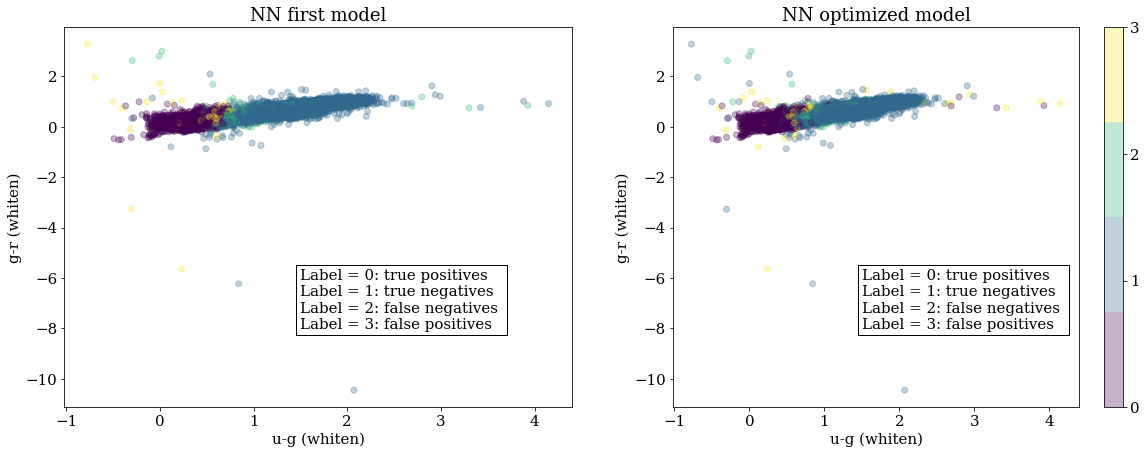

In [97]:
fig = plt.figure(figsize=(20,7))
cmap = plt.cm.get_cmap('viridis', 4)


label = [results(y_test, y_pred_gmmb), 
         results(y_test, y_pred_knn),
        results(y_test, y1_pred),
        results(y_test, y2_pred)
        ]


print('Label = 0: quasars correctly identified. \n'
       'Label = 1: galaxies correctly identified. \n'
        'Label = 2: quasars exchanged for galaxies. \n'
       'Label = 3: galaxies exchanged for quasars.'
     )


ax1 = fig.add_subplot(121)
ax1.scatter(X_test[:,0], X_test[:,1], alpha=0.3, c =label[0], cmap=cmap) 
ax1.set_title('GMMBayes')
ax1.set_xlabel('u-g (whiten)')
ax1.set_ylabel('g-r (whiten)')
ax1.text(1.5, -8, 'Label = 0: true positives \n'
       'Label = 1: true negatives \n'
        'Label = 2: false negatives \n'
       'Label = 3: false positives',
          bbox=dict(ec='k', fc='w'))


ax2 = fig.add_subplot(122)
ax2.scatter(X_test[:,0], X_test[:,1], alpha=0.3, c =label[1], cmap=cmap) 
ax2.set_title('KNeighborsClassifier')
ax2.set_xlabel('u-g (whiten)')
ax2.set_ylabel('g-r (whiten)')
ax2.text(1.5, -8, 'Label = 0: true positives \n'
       'Label = 1: true negatives \n'
        'Label = 2: false negatives \n'
       'Label = 3: false positives',
          bbox=dict(ec='k', fc='w'))


fig = plt.figure(figsize=(20,7))

ax3 = fig.add_subplot(121)
ax3.scatter(X_test[:,0], X_test[:,1], alpha=0.3, c =label[2], cmap=cmap) 
ax3.set_title('NN first model')
ax3.set_xlabel('u-g (whiten)')
ax3.set_ylabel('g-r (whiten)')
ax3.text(1.5, -8, 'Label = 0: true positives \n'
       'Label = 1: true negatives \n'
        'Label = 2: false negatives \n'
       'Label = 3: false positives',
          bbox=dict(ec='k', fc='w'))

ax4 = fig.add_subplot(122)
im = ax4.scatter(X_test[:,0], X_test[:,1], alpha=0.3, c =label[3], cmap=cmap) 
ax4.set_title('NN optimized model')
ax4.set_xlabel('u-g (whiten)')
ax4.set_ylabel('g-r (whiten)')
ax4.text(1.5, -8, 'Label = 0: true positives \n'
       'Label = 1: true negatives \n'
        'Label = 2: false negatives \n'
       'Label = 3: false positives',
          bbox=dict(ec='k', fc='w'))

cbar = fig.colorbar(im)
tick_locs = np.arange(4)
cbar.set_ticks(tick_locs);

ROC curves:

In [81]:
# first NN model
y1_prob = clf1.predict_proba(Xnn_test)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, y1_prob)

# optimized NN model
y2_prob = clf2.predict_proba(Xnn_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test, y2_prob)

# GMMBayes
y3_prob = gmmb.predict_proba(X_test)[:,1]
fpr3, tpr3, thresholds3 = roc_curve(y_test, y3_prob)

# KNN 
y4_prob= knn.predict_proba(X_test)[:,1]
fpr4, tpr4, thresholds4 = roc_curve(y_test, y4_prob)

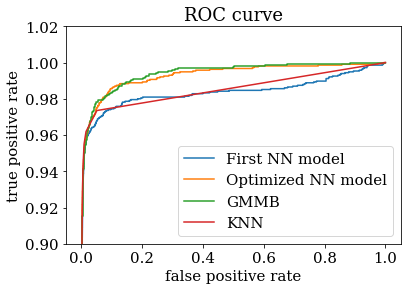

In [82]:
# plot
plt.plot(fpr1, tpr1, label='First NN model')
plt.plot(fpr2, tpr2, label='Optimized NN model')
plt.plot(fpr3, tpr3, label='GMMB')
plt.plot(fpr4, tpr4, label='KNN')

plt.xlabel('false positive rate')   # GAL said are QSO / all GAL
plt.ylabel('true positive rate')    # QSO rightly identified / all QSO
plt.title('ROC curve')
plt.legend()

plt.ylim(0.9, 1.02);

The performances of GMMB and of the optimized NN similar!
See also precision-recall curves:

In [83]:
pr1, rec1, t1 = precision_recall_curve(y_test, y1_prob)
pr2, rec2, t2 = precision_recall_curve(y_test, y2_prob)
pr3, rec3, t3 = precision_recall_curve(y_test, y3_prob)
pr4, rec4, t4 = precision_recall_curve(y_test, y4_prob)

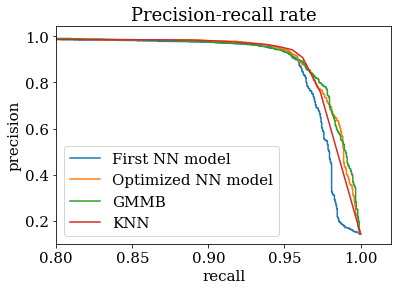

In [84]:
# plot
plt.plot(rec1, pr1, label='First NN model')
plt.plot(rec2, pr2,  label='Optimized NN model')
plt.plot(rec3, pr3, label='GMMB')
plt.plot(rec4, pr4, label='KNN')

plt.xlabel('recall')          # QSO rightly identified / all QSO
plt.ylabel('precision')       # 1 - GAL I said are QSO / #objects classified as QSO
plt.title('Precision-recall rate')
plt.legend()

plt.xlim(0.8, 1.02);

Model performances are similar!

The results obtained with the optimized neural network are comparable with the ones obtained with generative classifiers.

### Pytorch: NN with dropout

In [164]:
pip install optuna

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 kB 5.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 kB 4.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 9.4 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.5/203.5 kB 4.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (s

In [126]:
pip install plotly

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 10.0 MB/s eta 0:00:0000:0100:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near fu

In [23]:
import torch
import torch.nn as nn
#import torch.nn.functional as F
#import torch.utils.data as torchdata
from torch.utils.data import Dataset, DataLoader
import joblib
import optuna

In [24]:
# train data
class TrainData(Dataset):
  
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


# test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [25]:
'''
NN with the same number of neurons per each layer.
'''


# define structure of NN
class Net(nn.Module):
    
    '''
     define the building blocks of our model as class variables
    '''
    def __init__(self, input_size, Nhidden, hidden_size, num_classes, dropout_rate):
        
        super(Net, self).__init__()
        
        # list of layers
        self.layers = nn.ModuleList()
        
        # input
        actual_input = input_size
        
        # hidden layers
        for n in range(Nhidden):
           
            self.layers.append(nn.Linear(actual_input, hidden_size))
            self.layers.append(nn.Dropout(p=dropout_rate))
            self.layers.append(nn.ReLU())
            actual_input = hidden_size
            
        # output     
        self.layers.append(nn.Linear(actual_input, num_classes))
        self.layers.append(nn.Sigmoid())
            
            
    '''
     specifies how the data fed into the model needs to be processed in order to produce the output
    '''
    def forward(self, x):
        
        actual_data = x
        
        for layer in self.layers:
            out = layer(actual_data)
            actual_data = out
        
        return out

##### training the first model

In [26]:
# X and y have already cleaned data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=8)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=8)

batch_size = 64   

train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))  #torch.tensor is like np.array
test_data = TestData(torch.FloatTensor(X_test))
#val_data = TrainData(torch.FloatTensor(X_val), torch.FloatTensor(y_val))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data)
#val_loader = torch.utils.data.DataLoader(val_data)

In [27]:
def compute_accuracy(y_pred, y_test):
    
    y_pred_tag = torch.round(y_pred)
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = acc * 100
    
    return acc


'''
TRAIN STEP: trains the nn with train data and returns the mean loss and accuracy during epochs 
'''

def train_NN(model, train_loader, criterion, optimizer):
    
    # set the model to train mode
    model.train() 

    loss_train = 0
    acc_train = 0
        
    for X_batch, y_batch in train_loader:
            
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = compute_accuracy(y_pred, y_batch.unsqueeze(1))
            
        # Modification of parameters
        optimizer.zero_grad()              # Reset the gradients previously accumulated
        loss.backward()                    # Compute gradient of the loss 
        optimizer.step()                   # Update the weights 
        
        loss_train += loss.item()
        acc_train += acc.item()
            
    # saving average loss and accuracy for a single epoch
    mean_loss = loss_train/len(train_loader)   
    mean_acc = acc_train/len(train_loader)
        
    return  mean_loss, mean_acc


'''
VALIDATION STEP: uses the trained model to evaluate the mean loss and accuracy during epochs
'''

def validation(model, val_loader):
    
    model.eval() 
    
    loss_val = 0
    acc_val = 0
    
    with torch.no_grad():
        
        for X_batch, y_batch in val_loader:

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = compute_accuracy(y_pred, y_batch.unsqueeze(1))
        
            loss_val += loss.item()
            acc_val += acc.item()
    
    mean_loss = loss_val/len(val_loader)   
    mean_acc = acc_val/len(val_loader)
    
    return  mean_loss, mean_acc

In [28]:
# MODEL PARAMETERS
input_size = 4
Nhidden = 1
hidden_size = 5
num_classes = 1
dropout_rate = 0.   # for now no dropout

model = Net(input_size, Nhidden, hidden_size, num_classes, dropout_rate)
#print(model.parameters)

lr = 1e-3  
nepochs = 20

# LOSS FUNCTION AND OPTIMIZER
criterion = torch.nn.MSELoss(reduction='mean') 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


mean_loss = []
mean_acc = []
for epoch in range(1, nepochs + 1):  
    loss, acc = train_NN(model, train_loader, criterion, optimizer)
    mean_loss.append(loss)
    mean_acc.append(acc);

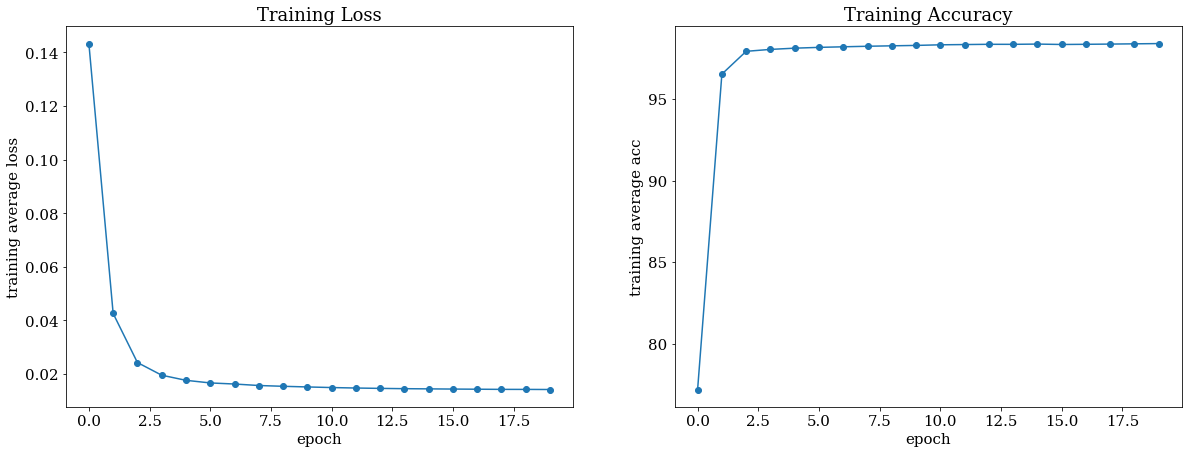

In [29]:
fig = plt.figure(figsize=(20,7))

ax1 = fig.add_subplot(121)
plt.plot(mean_loss,'-', label='training average loss')
plt.scatter(np.arange(0, nepochs), mean_loss)
plt.ylabel('training average loss')
plt.xlabel('epoch')
plt.title('Training Loss')

ax2 = fig.add_subplot(122)
plt.plot(mean_acc,'-', label='training average acc')
plt.scatter(np.arange(0, nepochs), mean_acc)
plt.ylabel('training average acc')
plt.xlabel('epoch')
plt.title('Training Accuracy');

##### test the first model

In [98]:
probs = model(torch.from_numpy(X_test.astype(np.float32)))
pred = torch.round(probs).detach().numpy()
probs = probs.detach().numpy()

C = confusion_matrix(y_test, pred)
accuracy = accuracy_score(y_test, pred)
pr, rec, t = precision_recall_curve(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)

print('\n accuracy', accuracy)
print('\n confusion matrix \n', C)


 accuracy 0.9865333333333334

 confusion matrix 
 [[12763    82]
 [  120  2035]]


#### Optimization of hyperparameters with optuna

In [59]:
# X and y have already cleaned data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=8)

batch_size = 64   

train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))  #torch.tensor is like np.array
test_data = TestData(torch.FloatTensor(X_test))
val_data = TrainData(torch.FloatTensor(X_val), torch.FloatTensor(y_val))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data)
val_loader = torch.utils.data.DataLoader(val_data)

In [60]:
def training(model, train_loader, val_loader, criterion, optimizer, epochs):
    
    for epoch in range(1, epochs + 1):        
        
        model.train()
        
        for X_batch, y_batch in train_loader:

            y_prediction = model(X_batch)
            loss = criterion(y_prediction, y_batch.unsqueeze(1)) 
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        acc_val = 0
        model.eval() 
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch, y_batch

                y_prediction = model(X_batch)
                acc = compute_accuracy(y_prediction, y_batch.unsqueeze(1))
                acc_val += acc.item()
                
    return acc_val/len(val_loader)



# define objective function
def optimization(trial):

    # model
    cfg = { 'seed' : 42,
           'nepochs': 20,
             'Nhidden' : trial.suggest_int('Nhidden', 1, 10, step = 1), 
             'hidden_size' : trial.suggest_int('hidden_size', 1, 100, step = 1), 
              'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),         
              'dropout_rate': trial.suggest_float('dropout', 0.1, 0.5, step=0.1),
              }
        
        
    torch.manual_seed(cfg['seed'])
    model = Net(input_size, cfg['Nhidden'], cfg['hidden_size'], num_classes, cfg['dropout_rate'])
    criterion = torch.nn.MSELoss(reduction='mean') 
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg['lr'])

    best_valid_acc = training(model, train_loader, val_loader, criterion, optimizer, 
                      epochs = cfg['nepochs'])

    return best_valid_acc

In [62]:
# the sampler determines the parameter values to be evaluated in a trial.
sampler = optuna.samplers.TPESampler()
    
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(func=optimization, n_trials=10)

# save into one file.
joblib.dump(study, './optuna_report1.pkl');

[I 2023-01-12 00:22:03,534] A new study created in memory with name: no-name-2a92ff20-54bf-4d55-a0c9-0d5852a56a64
[I 2023-01-12 00:23:13,461] Trial 0 finished with value: 98.64444444444445 and parameters: {'Nhidden': 9, 'hidden_size': 49, 'lr': 0.0024034024847978245, 'dropout': 0.1}. Best is trial 0 with value: 98.64444444444445.
[I 2023-01-12 00:23:36,150] Trial 1 finished with value: 98.53333333333333 and parameters: {'Nhidden': 1, 'hidden_size': 25, 'lr': 0.0004845348221857252, 'dropout': 0.2}. Best is trial 0 with value: 98.64444444444445.
[I 2023-01-12 00:24:25,292] Trial 2 finished with value: 98.55555555555556 and parameters: {'Nhidden': 7, 'hidden_size': 30, 'lr': 0.002903109375590445, 'dropout': 0.5}. Best is trial 0 with value: 98.64444444444445.
[I 2023-01-12 00:25:07,113] Trial 3 finished with value: 98.57777777777778 and parameters: {'Nhidden': 5, 'hidden_size': 44, 'lr': 0.00042606868175316736, 'dropout': 0.5}. Best is trial 0 with value: 98.64444444444445.
[I 2023-01-12 

In [63]:
study.best_trial

FrozenTrial(number=5, values=[98.71111111111111], datetime_start=datetime.datetime(2023, 1, 12, 0, 25, 46, 935044), datetime_complete=datetime.datetime(2023, 1, 12, 0, 26, 54, 872699), params={'Nhidden': 8, 'hidden_size': 98, 'lr': 0.00011326730418252919, 'dropout': 0.1}, distributions={'Nhidden': IntDistribution(high=10, log=False, low=1, step=1), 'hidden_size': IntDistribution(high=100, log=False, low=1, step=1), 'lr': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'dropout': FloatDistribution(high=0.5, log=False, low=0.1, step=0.1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=5, state=TrialState.COMPLETE, value=None)

In [100]:
optuna.visualization.plot_optimization_history(study)

In [65]:
Nhidden = study.best_trial.params['Nhidden']
hidden_size = study.best_trial.params['hidden_size']
dropout_rate = study.best_trial.params['dropout']
lr = study.best_trial.params['lr']

model = Net(input_size, Nhidden, hidden_size, num_classes, dropout_rate)
criterion = torch.nn.MSELoss(reduction='mean') 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, nepochs + 1):  
    loss_t, acc_t = train_NN(model, train_loader, criterion, optimizer)
    loss_v, acc_v = validation(model, val_loader)
    train_loss.append(loss_t)
    train_acc.append(acc_t)
    val_loss.append(loss_v)
    val_acc.append(acc_v)

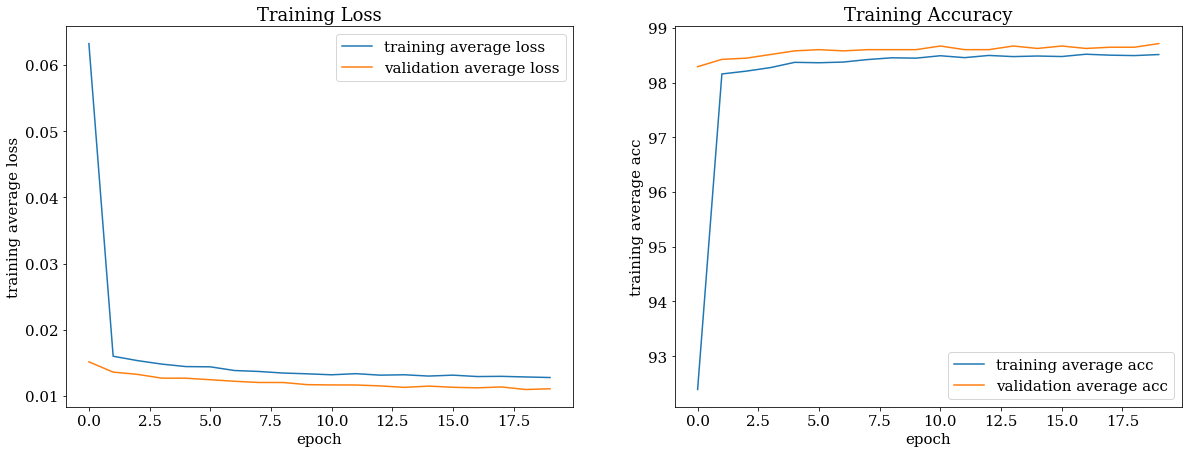

In [74]:
fig = plt.figure(figsize=(20,7))

ax1 = fig.add_subplot(121)
plt.plot(train_loss,'-', label='training average loss')
plt.plot(val_loss,'-', label='validation average loss')
plt.ylabel('training average loss')
plt.xlabel('epoch')
plt.title('Training Loss')
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(train_acc,'-', label='training average acc')
plt.plot(val_acc,'-', label='validation average acc')
plt.ylabel('training average acc')
plt.xlabel('epoch')
plt.title('Training Accuracy')
plt.legend();

In [75]:
probs2 = model(torch.from_numpy(X_test.astype(np.float32)))
pred2 = torch.round(probs2).detach().numpy()
probs2 = probs2.detach().numpy()

C2 = confusion_matrix(y_test, pred2)
accuracy2 = accuracy_score(y_test, pred2)
pr_2, rec_2, t_2 = precision_recall_curve(y_test, probs2)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probs2)

print('\n accuracy', accuracy2)
print('\n confusion matrix \n', C2)


 accuracy 0.9844

 confusion matrix 
 [[4267   37]
 [  41  655]]
